Overview
This notebook demonstrates the training process of a Graph-based Wasserstein Autoencoder (GWAE) for generating geological models under uncertainty. The GWAE is a graph-based variational autoencoder architecture designed to handle different geological scenarios (e.g., models with varying numbers of channels) by learning a low-dimensional latent space representation
researchgate.net
. Unlike traditional grid-based approaches, this model uses graph convolutional neural networks to encode and decode reservoir models, allowing it to preserve geological realism and spatial relationships in the data
researchgate.net
. The latent space of the GWAE can be used to implicitly control geological realism (for example, through geodesic interpolation between latent points) and to analyze the variability of geological scenarios via techniques like PCA or t-SNE
researchgate.net
. Workflow Summary:
Data Loading: The dataset (a list of graph objects) is loaded from a pickle file. Each graph represents a 3D channelized reservoir model with node features such as porosity and permeability.
Preprocessing: Porosity and permeability features are normalized. Porosity is scaled to [-1, 1] and permeability (originally log-normally distributed) is transformed to a normal distribution for stable training.
Model Setup: Key hyperparameters are defined (latent dimension, learning rates, etc.). A PyTorch Geometric DataLoader is prepared for batching the graphs. The GWAE model and trainer are initialized. The model employs a Wasserstein AutoEncoder approach using a Maximum Mean Discrepancy (MMD) loss (with an RBF kernel) to match the latent distribution to a prior.
Training: The trainer can run two training phases: one for the autoencoder's main parameters (µ training for a number of epochs) and an optional fine-tuning for the MMD kernel width (σ training). Training metrics are logged using TensorBoard's SummaryWriter. (In this notebook, a pre-trained model state is loaded for demonstration. To reproduce training from scratch, you can skip loading the weights and train for the specified epochs.)
Evaluation: The trained model is tested on the dataset (e.g., reconstructing the input graphs). Predictions and true values are collected for analysis.
Visualization: The reconstruction performance is visualized. For instance, the code uses custom visual_tools to plot how well the GWAE reconstructs properties like porosity and permeability across the reservoir model. This helps verify that the GWAE preserves petrophysical relationships and spatial structures in the generated models
researchgate.net
.

## Environment Setup and Imports

In [9]:
# Enable automatic reloading of imported modules for iterative development
%load_ext autoreload
%autoreload 2

# Set an environment variable to help with CUDA debugging (if using GPU)
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # helps with debugging CUDA errors by making them synchronous

# Import essential libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  # for inline plotting in Jupyter

# Import PyTorch and related utilities
import torch
import torch.utils.data  # data utilities in PyTorch
from torch.utils.tensorboard import SummaryWriter  # for logging training metrics to TensorBoard

# Import PyTorch Geometric for graph data handling
import torch_geometric
from torch_geometric.data import Data, DataLoader  # Data structure for graphs and a DataLoader for batching

# Import custom dataset loading function (assumes `data.py` provides get_dataset)
from data import get_dataset

# Import custom utility modules for this project
import useful_custom_functions  # contains custom data transformation functions
from grid import load_grid, show_grid, Graph_to_Grid   # for handling grid representations of graph data
from curve import connecting_geodesic, linear_interpolation  # for latent space interpolation (geodesic vs linear)

# Ensure CUDA synchronous execution is set again (if needed, redundant with above)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Import custom smoothness metrics and plotting (for evaluating latent space interpolation smoothness)
from smoothness import smoothness_factor_simple, plot_smoothness

# Import everything from the GWAE model/trainer module (assumes `GVWAE.py` defines the model and TrainerRBF class)
from GVWAE import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


UsageError: unrecognized arguments: # for inline plotting in Jupyter


## Data Loading and Preprocessing


In [1]:
# Load the preprocessed dataset from a pickle file
import pickle 
with open('dataset.pickle', 'rb') as f:
    dataset_list = pickle.load(f)

## Inspecting and Combining Feature Distributions

In [4]:
# Extract porosity and permeability features from all graphs for analysis
poro = []
perm = []

for graph in dataset_list:
    poro.append(graph.x[:, 0].cpu())  # first feature (porosity) of all nodes in the graph
    perm.append(graph.x[:, 1].cpu())  # second feature (permeability) of all nodes in the graph

# Concatenate all porosity and permeability values from the entire dataset into single arrays
poro = np.concatenate(poro, axis=0)
perm = np.concatenate(perm, axis=0)


Normalizing perm, cause it's in log-norm

In [5]:
# Transform permeability from log-normal distribution to a normal distribution for normalization
transformer, perm_normalized = useful_custom_functions.from_lognorm_to_norm(perm)

Showing property distributions

In [6]:
# Apply the normalization to the entire dataset's features
perm_normalized = transformer.transform(perm.reshape(-1, 1))  # transform all perm values to normal distribution
max_perm = np.max(np.abs(perm_normalized))    # find the max absolute value of normalized perm (for scaling)
max_poro = np.max(np.abs(poro))               # find the max absolute porosity value (assuming porosity is zero-centered or raw)

# Normalize each graph in the dataset
for i in range(len(dataset_list)):
    # Scale porosity (feature 0) by the global max to bound it between -1 and 1
    dataset_list[i].x[:, 0] /= max_poro

    # Transform permeability (feature 1) using the fitted transformer, then scale similarly
    perm_values = dataset_list[i].x[:, 1].reshape(-1, 1).cpu()    # get permeability values for the graph's nodes
    perm_values = transformer.transform(perm_values)             # apply lognorm->norm transformation
    dataset_list[i].x[:, 1] = torch.tensor(perm_values[:, 0].copy())  # replace feature 1 with normalized values


## Model Configuration and Training Setup

In [7]:
# Training hyperparameters
mu_epochs = 50       # number of epochs to train the autoencoder (mu updates)
sigma_epochs = 1     # number of epochs to train the latent distribution (sigma updates for MMD, if any)
batch_size = 1       # batch size (graphs per batch). Using 1 here since each graph might be large.
nv = 1919            # number of vertices (nodes) in each graph
nz = 30              # latent space dimensionality (size of the latent vector z)
writer = SummaryWriter()  # TensorBoard writer for logging training metrics

In [8]:
# Create a DataLoader for the training data
train_loader = DataLoader(dataset_list, batch_size=batch_size, shuffle=True)

In [9]:
# Initialize the GWAE model trainer with specified architecture and parameters
trainer = TrainerRBF(
    batch_size=batch_size,
    nv=nv,
    nz=nz,
    model_loss='mmd',          # use MMD loss for the latent space (Wasserstein AE)
    gamma=1,                   # weight for the MMD regularization term (could be λ in WAE objective)
    channels=2,                # number of input feature channels (2 features: porosity and permeability)
    num_centers=1000,          # parameter for RBF/MMD (e.g., number of sample points for kernel or centers for RBF)
    edge_index=next(iter(train_loader)).edge_index,  # graph connectivity (use the first graph's edges as a template)
    writer=writer,             # TensorBoard writer for logging
    middle_layer_size=500,     # size of hidden layers in the networks (e.g., neurons in fully connected layers)
    middle_channels=8,         # number of channels in hidden graph conv layers (if using graph convolutions)
    warmup_learning_rate=1e-5, # initial learning rate for warm-up (if a learning rate scheduling is used)
    sigma_learning_rate=1e-5   # learning rate for σ (if optimizing kernel bandwidth for MMD)
)

## Model Training

In [10]:
# (Optional) Load a pre-trained model state if available, to skip directly to evaluation
trainer.model.load_state_dict(torch.load('rvae.pt'), strict=False)

<All keys matched successfully>

In [11]:
# Define the path prefix for results (e.g., saving figures or outputs)
path_prefix

'../DATA/3_types_of_channels_with_stats/'

## Model Evaluation (Test Stage)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 136.70it/s]


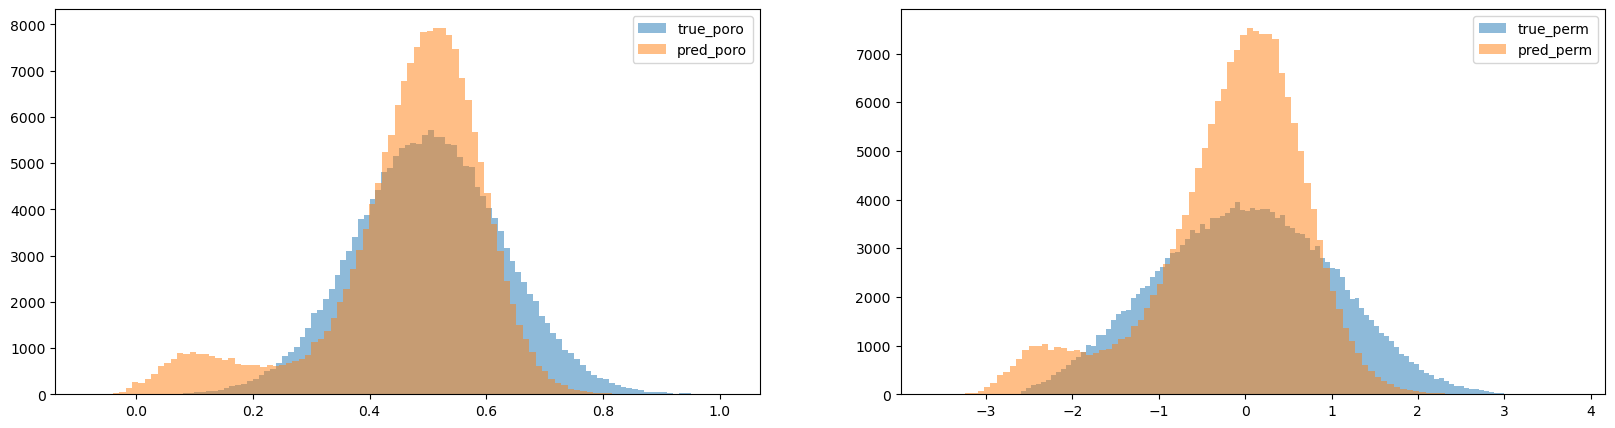

In [12]:
# Switch model to evaluation mode and test on the training set
preds = []
trues = []

for data in tqdm(train_loader):
    # Get the model's reconstruction for the batch (and possibly latent variables, which we ignore here)
    pred, _ = trainer.test_on_batch(data)
    # Collect the prediction (output graph's node features) and true values for comparison
    preds.append(pred.cpu().detach().numpy())
    trues.append(np.reshape(data.x.cpu().detach().numpy(), (batch_size, nv, 2)))

# Visualize the training/test results using the custom visual tool
fig = visual_tools.training_process(trues, preds, path_prefix + 'figs/test')

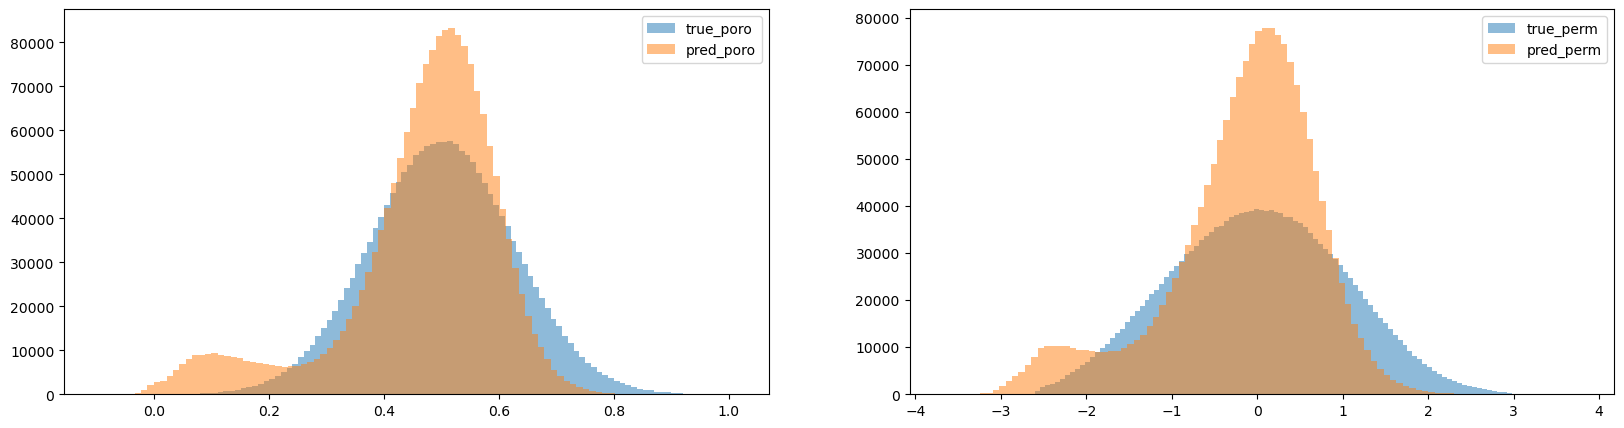

In [14]:
fig = visual_tools.training_process(trues, preds, path_prefix + 'figs/test')

# 